In [ ]:
# 1. Create a wrapper function that will calculate Mlk_NP_g
# 2. Create DAG for the functions used in the wrapper TODO
# 3. Create standard structure for wrapper and calculation functions TODO


In [1]:
# Define all calculation functions needed localy so I can manipulate if needed

import nasem_dairy as nd
import pandas as pd
import math
import numpy as np

def calculate_Mlk_NP_g(An_BW, 
                       An_StatePhys, 
                       Dt_DMIn,
                       df,
                       Dt_idRUPIn, 
                       Du_idMiCP_g, 
                       An_DEIn, 
                       An_DETPIn, 
                       An_DENPNCPIn, 
                       An_DigNDFIn, 
                       An_DEStIn, 
                       An_DEFAIn, 
                       An_DErOMIn, 
                       An_DENDFIn, 
                       coeff_dict):
    """
    Predicts net protein output in milk 

    Paramters:
        df (Dataframe): A dataframe with indivual amino acid intakes and flows, AA_values in the model
        Dt_idRUPIn (Number): Intestinally digested rumen undegradable protein intake, kg/d
        Du_idMiCP_g (Number): Intestinally digested microbial crude protein, g/d
        An_DEIn (Number): Digestible energy intake in Mcal/d
        An_DETPIn (Number): Digestible energy from true protein, Mcal/d
        An_DENPNCPIn (Number): Digestible energy crud eprotein synthesized from non protein nitrogen (NPN), Mcal/d
        An_DigNDFIn (Number): Digestable neutral detergent fiber (NDF) intake, Mcal/d
        An_DEStIn (Number): Digestible energy from starch, Mcal/d
        An_DEFAIn (Number): Digestible energy from fatty acids, Mcal/d
        An_DErOMIn (Number): Digestible energy from residual organic matter, Mcal/d
        An_DENDFIn (Number): Digestible energy from neutral detergent fiber (NDF), Mcal
        An_BW (Number): Animal bodyweight, kg
        Dt_DMIn (Number): Dry matter intake, kg/d
        coeff_dict (Dict): Dictionary containing all coefficients for the model

    Returns:
        Mlk_NP_g (Number): Net protein in milk, g/d
        An_DigNDF (Number): Total tract digested neutral detergent fiber
        An_MPIn (Number): Metabolizlable protein intake, kg/d
    """
    
    req_coeffs = ['mPrt_Int', 'fMiTP_MiCP', 'mPrt_k_NEAA', 'mPrt_k_OthAA', 
                  'mPrt_k_DEInp', 'mPrt_k_DigNDF', 'mPrt_k_DEIn_StFA', 'mPrt_k_DEIn_NDF', 'mPrt_k_BW']     
    nd.check_coeffs_in_coeff_dict(coeff_dict, req_coeffs)

    An_DigNDF = An_DigNDFIn / Dt_DMIn * 100
    # Unpack the AA_values dataframe into dictionaries
    AA_list = ['Arg', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Thr', 'Trp', 'Val']
    Abs_AA_g = {}
    mPrt_k_AA = {}

    for AA in AA_list:
        Abs_AA_g[AA] = df.loc[AA, 'Abs_AA_g']
        mPrt_k_AA[AA] = df.loc[AA, 'mPrt_k_AA']

    # Calculate Mlk_NP_g
    Abs_EAA_g = Abs_AA_g['Arg'] + Abs_AA_g['His'] + Abs_AA_g['Ile'] + Abs_AA_g['Leu'] + Abs_AA_g['Lys'] \
                + Abs_AA_g['Met'] + Abs_AA_g['Phe'] + Abs_AA_g['Thr'] + Abs_AA_g['Trp'] + Abs_AA_g['Val']

    Du_idMiTP_g = coeff_dict['fMiTP_MiCP'] * Du_idMiCP_g              # Line 1182
    Du_idMiTP = Du_idMiTP_g / 1000
    An_MPIn = Dt_idRUPIn + Du_idMiTP                    # Line 1236 (Equation 20-136 p. 432 - without infused TP)
    An_MPIn_g = An_MPIn * 1000                          # Line 1238 
    Abs_neAA_g = An_MPIn_g * 1.15 - Abs_EAA_g           # Line 1771 (Equation 20-150 p. 433)
    Abs_OthAA_g = Abs_neAA_g + Abs_AA_g['Arg'] + Abs_AA_g['Phe'] + Abs_AA_g['Thr'] + Abs_AA_g['Trp'] + Abs_AA_g['Val'] #Equation 20-186a, p. 436
    Abs_EAA2b_g = Abs_AA_g['His']**2 + Abs_AA_g['Ile']**2 + Abs_AA_g['Leu']**2 + Abs_AA_g['Lys']**2 + Abs_AA_g['Met']**2        # Line 2106, 1778; (Equation 20-186b p. 436)
    mPrtmx_Met2 = df.loc['Met', 'mPrtmx_AA2']
    mPrt_Met_0_1 = df.loc['Met', 'mPrt_AA_0.1']
    # Cannot call the variable mPrt_Met_0.1 in python, this is the only variable not consistent with R code
    Met_mPrtmx = df.loc['Met', 'AA_mPrtmx']
    An_DEInp = An_DEIn - An_DETPIn - An_DENPNCPIn

    #Scale the quadratic; can be calculated from any of the AA included in the squared term. All give the same answer
    mPrt_k_EAA2 = (2 * math.sqrt(mPrtmx_Met2**2 - mPrt_Met_0_1 * mPrtmx_Met2) - 2 * mPrtmx_Met2 + mPrt_Met_0_1) / (Met_mPrtmx * 0.1)**2
   

    Mlk_NP_g = coeff_dict['mPrt_Int'] + Abs_AA_g['Arg'] * mPrt_k_AA['Arg'] + Abs_AA_g['His'] * mPrt_k_AA['His'] \
                + Abs_AA_g['Ile'] * mPrt_k_AA['Ile'] + Abs_AA_g['Leu'] * mPrt_k_AA['Leu'] \
                + Abs_AA_g['Lys'] * mPrt_k_AA['Lys'] + Abs_AA_g['Met'] * mPrt_k_AA['Met'] \
                + Abs_AA_g['Phe'] * mPrt_k_AA['Phe'] + Abs_AA_g['Thr'] * mPrt_k_AA['Thr'] \
                + Abs_AA_g['Trp'] * mPrt_k_AA['Trp'] + Abs_AA_g['Val'] * mPrt_k_AA['Val'] \
                + Abs_neAA_g * coeff_dict['mPrt_k_NEAA'] + Abs_OthAA_g * coeff_dict['mPrt_k_OthAA'] + Abs_EAA2b_g * mPrt_k_EAA2 \
                + An_DEInp * coeff_dict['mPrt_k_DEInp'] + (An_DigNDF - 17.06) * coeff_dict['mPrt_k_DigNDF'] + (An_DEStIn + An_DEFAIn + An_DErOMIn) \
                * coeff_dict['mPrt_k_DEIn_StFA'] + An_DENDFIn * coeff_dict['mPrt_k_DEIn_NDF'] + (An_BW - 612) * coeff_dict['mPrt_k_BW'] 

    if An_StatePhys != "Lactating Cow":                 # Line 2204
        Mlk_NP_g = 0

    return Mlk_NP_g #, An_DigNDF, An_MPIn, An_DEInp


def AA_calculations(Du_MiN_g, feed_data, diet_info, animal_input, coeff_dict):
    """
    Takes the amino acid (AA) supply from the diet and calculates total AA intake

    This takes the AA supply from each feed based on % crude protein and the predicted AA supply from microbial nitrogen (N) 
    and uses this to calculate individual AA flows through the body. 

    Parameters:
        Du_MiN_g (Number): Microbial N supply in g, Du_MiN_NRC2021_g in the model
        feed_data (Dataframe): A dataframe with the composition of each feed ingredient
        diet_info (Dataframe): A dataframe with nutrient supply from the diet
        animal_input (Dictionary): All the user entered animal parameters
        coeff_dict (Dict): Dictionary containing all coefficients for the model
        
    Returns:
        AA_values (Dataframe): Contains all the AA intakes and any values calculated for individual AAs
        Du_MiCP_g (Number): Microbial crude proetin, g
    """
    # This function will get the intakes of AA's from the diet and then do all the calculations of values other functions will need
    # The results will be saved to a dataframe with one row for each AA and a column for each calculated value
    AA_list = ['Arg', 'His', 'Ile', 'Leu', 'Lys', 'Met', 'Phe', 'Thr', 'Trp', 'Val']
    AA_values = pd.DataFrame(index=AA_list)
    Dt_IdAARUPIn = {}

    ####################
    # Get Diet Data
    ####################
    feed_columns = ['Fd_Arg_CP', 'Fd_His_CP', 'Fd_Ile_CP', 'Fd_Leu_CP', 'Fd_Lys_CP', 'Fd_Met_CP', 'Fd_Phe_CP', 'Fd_Thr_CP', 'Fd_Trp_CP', 'Fd_Val_CP', 'Fd_dcRUP']
    df_f = pd.DataFrame(feed_data[feed_columns])

    df_f['Fd_RUPIn'] = None
    dict_Fd_RUPIn = diet_info.set_index('Feedstuff')['Fd_RUPIn'].to_dict()
    for feedstuff_name in df_f.index:
        RUPin_value = dict_Fd_RUPIn.get(feedstuff_name)
        df_f.loc[feedstuff_name, 'Fd_RUPIn'] = RUPin_value
        
    ####################
    # Define Variables
    ####################
    
    req_coeffs = ['fMiTP_MiCP', 'SI_dcMiCP', 'K_305RHA_MlkTP', 'RecArg', 'RecHis',
    'RecIle', 'RecLeu', 'RecLys', 'RecMet', 'RecPhe',
    'RecThr', 'RecTrp', 'RecVal', 'MiTPArgProf', 'MiTPHisProf',
    'MiTPIleProf', 'MiTPLeuProf', 'MiTPLysProf', 'MiTPMetProf', 'MiTPPheProf',
    'MiTPThrProf', 'MiTPTrpProf', 'MiTPValProf', 'mPrt_k_Arg_src', 'mPrt_k_His_src',
    'mPrt_k_Ile_src', 'mPrt_k_Leu_src', 'mPrt_k_Lys_src', 'mPrt_k_Met_src', 'mPrt_k_Phe_src',
    'mPrt_k_Thr_src', 'mPrt_k_Trp_src', 'mPrt_k_Val_src', 'mPrt_k_EAA2_src']
    nd.check_coeffs_in_coeff_dict(coeff_dict, req_coeffs)
    
    An_305RHA_MlkTP = animal_input['An_305RHA_MlkTP']
    f_mPrt_max = 1 + coeff_dict['K_305RHA_MlkTP'] * (An_305RHA_MlkTP / 280 - 1)       # Line 2116, 280kg RHA ~ 930 g mlk NP/d herd average
    Du_MiCP_g = Du_MiN_g * 6.25                                         # Line 1163
    Du_MiTP_g = coeff_dict['fMiTP_MiCP'] * Du_MiCP_g                                  # Line 1166

    # Digested endogenous protein is ignored as it is a recycle of previously absorbed AA.
    # SI Digestibility of AA relative to RUP digestibility ([g dAA / g AA] / [g dRUP / g RUP])
    # All set to 1 due to lack of clear evidence for deviations.
    SIDigArgRUPf = 1
    SIDigHisRUPf = 1
    SIDigIleRUPf = 1
    SIDigLeuRUPf = 1
    SIDigLysRUPf = 1
    SIDigMetRUPf = 1
    SIDigPheRUPf = 1
    SIDigThrRUPf = 1
    SIDigTrpRUPf = 1
    SIDigValRUPf = 1

    for AA in AA_list:
        ##############################
        # Calculations on Diet Data
        ##############################
        # Fd_AAt_CP         
        df_f['Fd_{}t_CP'.format(AA)] = df_f['Fd_{}_CP'.format(AA)] / coeff_dict['Rec{}'.format(AA)]

        # Fd_AARUPIn         
        df_f['Fd_{}RUPIn'.format(AA)] = df_f['Fd_{}t_CP'.format(AA)] / 100 * df_f['Fd_RUPIn'] * 1000

        # Fd_IdAARUPIn      
        # Note: eval() is used to access SIDig__ values defined above
        df_f['Fd_Id{}RUPIn'.format(AA)] = df_f['Fd_dcRUP'] / 100 * df_f['Fd_{}RUPIn'.format(AA)] * eval('SIDig{}RUPf'.format(AA))
    
        # Dt_IdAARUPIn      
        Dt_IdAARUPIn['Dt_Id{}_RUPIn'.format(AA)] = df_f['Fd_Id{}RUPIn'.format(AA)].sum()

        ########################################
        # Calculations for Microbial Protein and Total AA Intake
        ########################################
        # Du_AAMic      
        AA_values.loc[AA, 'Du_AAMic'] = Du_MiTP_g * coeff_dict['MiTP{}Prof'.format(AA)] / 100         # Line 1573-1582

        # Du_IdAAMic        
        AA_values.loc[AA, 'Du_IdAAMic'] = AA_values.loc[AA, 'Du_AAMic'] * coeff_dict['SI_dcMiCP'] / 100       # Line 1691-1700

        # Abs_AA_g
        # No infusions so Dt_IdAAIn, An_IdAA_In and Abs_AA_g are all the same value in this case
        AA_values.loc[AA, 'Abs_AA_g'] = AA_values.loc[AA, 'Du_IdAAMic'] + Dt_IdAARUPIn['Dt_Id{}_RUPIn'.format(AA)]     # Line 1703, 1714, 1757

        ########################################
        # Calculations for AA coefficients
        ########################################
        #mPrtmx_AA      
        AA_values.loc[AA, 'mPrtmx_AA'] = -(coeff_dict['mPrt_k_{}_src'.format(AA)])**2 / (4 * coeff_dict['mPrt_k_EAA2_src'])
        
        #mPrtmx_AA2        
        AA_values.loc[AA, 'mPrtmx_AA2'] = AA_values.loc[AA, 'mPrtmx_AA'] * f_mPrt_max                   # Line 2149-2158

        #AA_mPrtmx
        AA_values.loc[AA, 'AA_mPrtmx'] = -(coeff_dict['mPrt_k_{}_src'.format(AA)]) / (2 * coeff_dict['mPrt_k_EAA2_src'])

        #mPrt_AA_0.1
        AA_values.loc[AA, 'mPrt_AA_0.1'] = AA_values.loc[AA, 'AA_mPrtmx'] * 0.1 * coeff_dict['mPrt_k_{}_src'.format(AA)] \
                                           + (AA_values.loc[AA, 'AA_mPrtmx'] * 0.1)**2 * coeff_dict['mPrt_k_EAA2_src']

        #mPrt_k_AA
        if AA_values.loc[AA, 'mPrtmx_AA2'] ** 2 - AA_values.loc[AA, 'mPrt_AA_0.1'] * AA_values.loc[AA, 'mPrtmx_AA2'] <= 0 or AA_values.loc[AA, 'AA_mPrtmx'] == 0:
        # Check for sqrt of 0 or divide by 0 errors and set value to 0 if encountered
            AA_values.loc[AA, 'mPrt_k_AA'] = 0
        else:
            AA_values.loc[AA, 'mPrt_k_AA'] = -(2 * np.sqrt(AA_values.loc[AA, 'mPrtmx_AA2'] ** 2 \
                                                - AA_values.loc[AA, 'mPrt_AA_0.1'] * AA_values.loc[AA, 'mPrtmx_AA2']) \
                                                - 2 * AA_values.loc[AA, 'mPrtmx_AA2']) \
                                                / (AA_values.loc[AA, 'AA_mPrtmx'] * 0.1)
    
    # df_f and Dt_IdAARUPIn not being returned but can be if values are needed outside this function
    # Currently they are not used anywhere else
    return AA_values, Du_MiCP_g


def calculate_An_DEIn(Dt_DigNDFIn_Base, Dt_NDFIn, Dt_DigStIn_Base, Dt_StIn, Dt_DigrOMtIn, Dt_CPIn, Dt_RUPIn, Dt_idRUPIn, Dt_NPNCPIn, Dt_DigFAIn, Du_MiCP_g, An_BW, Dt_DMIn, coeff_dict):
    """
    Digestable energy (DE) supply

    Calculates DE for each feed component as well as a total DE intake

    Parameters:
        Dt_DigNDFIn_Base (Number): Digestable neutral detergent fiber (NDF) intake, kg/d
        Dt_NDFIn (Number): Neutral detergent fiber (NDF) intake in kg/d
        Dt_DigStIn_Base (Number): Digestable starch intake, kg/d
        Dt_StIn (Number): Starch intake in kg/d
        Dt_DigrOMtIn (Number): Digestable residual organic matter intake, kg/d
        Dt_CPIn (Number): Crude protein (CP) intake in kg/d
        Dt_RUPIn (Number): Rumen undegradable protein (RUP) in kg/d
        Dt_idRUPIn (Number): Intestinally digested rumen undegradable protein intake, kg/d
        Dt_NPNCPIn (Number): Crude protein from non-protein nitrogen (NPN) intake, kg/d
        Dt_DigFAIn (Number): Digestable fatty acid intake, kg/d
        Du_MiCP_g (Number): Microbial crude proetin, g
        An_BW (Number): Animal bodyweight in kg
        Dt_DMIn (Number): Dry matter intake, kg/d
        coeff_dict (Dict): Dictionary containing all coefficients for the model

    Returns:
        An_DEIn (Number): Digestible energy intake in Mcal/d
        An_DENPNCPIn (Number): Digestible energy crud eprotein synthesized from non protein nitrogen (NPN), Mcal/d
        An_DETPIn (Number): Digestible energy from true protein, Mcal/d
        An_DigNDFIn (Number): Digestable neutral detergent fiber (NDF) intake, Mcal/d
        An_DEStIn (Number): Digestible energy from starch, Mcal/d
        An_DEFAIn (Number): Digestible energy from fatty acids, Mcal/d
        An_DErOMIn (Number): Digestible energy from residual organic matter, Mcal/d
        An_DENDFIn (Number): Digestible energy from neutral detergent fiber (NDF), Mcal
        Fe_CP (Number): Fecal crude protein, kg/d
        Fe_CPend_g (Number): Fecal crude protein coming from endogenous secretions
        Du_idMiCP_g (Number): Intestinally digested microbial crude protein, g/d
    """
# Consider renaiming as this really calculates all of the DE intakes as well as the total

    req_coeffs = ['En_NDF', 'En_St', 'En_rOM', 'Fe_rOMend_DMI', 
                  'SI_dcMiCP', 'En_CP', 'dcNPNCP', 'En_NPNCP', 'En_FA']
    nd.check_coeffs_in_coeff_dict(coeff_dict, req_coeffs)

    # Replaces An_NDF as input
    An_NDF = Dt_NDFIn / Dt_DMIn * 100

    #An_DigNDFIn#
    TT_dcNDF_Base = Dt_DigNDFIn_Base / Dt_NDFIn * 100                     # Line 1056
    if math.isnan(TT_dcNDF_Base) is True:
        TT_dcNDF_Base = 0

    An_DMIn_BW = Dt_DMIn / An_BW
    # En_NDF = 4.2

    if TT_dcNDF_Base == 0:
        TT_dcNDF = 0
    else:
        TT_dcNDF = (TT_dcNDF_Base / 100 - 0.59 * (Dt_StIn / Dt_DMIn - 0.26) - 1.1 * (An_DMIn_BW - 0.035)) * 100       # Line 1060


    Dt_DigNDFIn = TT_dcNDF / 100 * Dt_NDFIn
    
    
    An_DigNDFIn = Dt_DigNDFIn + 0 * TT_dcNDF/100                                    # Line 1063, the 0 is a placeholder for InfRum_NDFIn, ask Dave about this, I think the TT_dcNDF is not needed
    An_DENDFIn = An_DigNDFIn * coeff_dict['En_NDF']                                               # Line 1353
    
    #An_DEStIn#
    # En_St = 4.23                                                                   # Line 271
    TT_dcSt_Base = Dt_DigStIn_Base / Dt_StIn * 100                                 # Line 1030    
    if math.isnan(TT_dcSt_Base) is True:
        TT_dcSt_Base = 0

    if TT_dcSt_Base == 0:
        TT_dcSt = 0
    else:
        TT_dcSt = TT_dcSt_Base - (1.0 * (An_DMIn_BW - 0.035)) * 100                 # Line 1032
    An_DigStIn = Dt_StIn * TT_dcSt / 100                                            # Line 1033
    An_DEStIn = An_DigStIn * coeff_dict['En_St']                                                  # Line 1351

    #An_DErOMIn#
    # En_rOM = 4.0                                                                    # Line 271
    # Fe_rOMend_DMI = 3.43                                                            # Line 1005, 3.43% of DMI
    Fe_rOMend = coeff_dict['Fe_rOMend_DMI'] / 100 * Dt_DMIn                               	    # Line 1007, From Tebbe et al., 2017.  Negative interecept represents endogenous rOM
    An_DigrOMaIn = Dt_DigrOMtIn - Fe_rOMend                                         # Line 1024, 1022
    An_DErOMIn = An_DigrOMaIn * coeff_dict['En_rOM']                                              # Line 1352

    #An_DETPIn#
    # SI_dcMiCP = 80			                                                    	# Line 1123, Digestibility coefficient for Microbial Protein (%) from NRC 2001 
    # En_CP = 5.65                                                                    # Line 266
    # dcNPNCP = 100	                                                                # Line 1092, urea and ammonium salt digestibility
    # En_NPNCP = 0.89                                                                 # Line 270
    An_idRUPIn = Dt_idRUPIn                                       # Line 1099
    Fe_RUP = Dt_RUPIn - An_idRUPIn                                                  # Line 1198   
    Du_MiCP = Du_MiCP_g / 1000                                                      # Line 1166
    Du_idMiCP_g = coeff_dict['SI_dcMiCP'] / 100 * Du_MiCP_g
    Du_idMiCP = Du_idMiCP_g / 1000
    Fe_RumMiCP = Du_MiCP - Du_idMiCP                                                # Line 1196
    Fe_CPend_g = (12 + 0.12 * An_NDF) * Dt_DMIn            # line 1187, g/d, endogen secretions plus urea capture in microbies in rumen and LI
    Fe_CPend = Fe_CPend_g / 1000                                                    # Line 1190
    Fe_CP = Fe_RUP + Fe_RumMiCP + Fe_CPend          # Line 1202, Double counting portion of RumMiCP derived from End CP. Needs to be fixed. MDH
    An_DigCPaIn = Dt_CPIn - Fe_CP		            # Line 1222, apparent total tract
    An_DECPIn = An_DigCPaIn * coeff_dict['En_CP']
    An_DENPNCPIn = Dt_NPNCPIn * coeff_dict['dcNPNCP'] / 100 * coeff_dict['En_NPNCP']                                                          # Line 1355, 1348
    
    # Line 1356, Caution! DigTPaIn not clean so subtracted DE for CP equiv of NPN to correct. Not a true DE_TP.
    An_DETPIn = An_DECPIn - An_DENPNCPIn / coeff_dict['En_NPNCP'] * coeff_dict['En_CP']                      

    #An_DEFAIn#
    # En_FA = 9.4                                                                                         # Line 265
    An_DigFAIn = Dt_DigFAIn                                                                             # Line 1309
    An_DEFAIn = An_DigFAIn * coeff_dict['En_FA']

    An_DEIn = An_DENDFIn + An_DEStIn + An_DErOMIn + An_DETPIn + An_DENPNCPIn + An_DEFAIn  # Line 1367

    return An_DEIn, An_DENPNCPIn, An_DETPIn, An_DigNDFIn, An_DEStIn, An_DEFAIn, An_DErOMIn, An_DENDFIn, Fe_CP, Fe_CPend_g, Du_idMiCP_g


def calculate_Du_MiN_g(Dt_NDFIn, Dt_DMIn, Dt_StIn, Dt_CPIn, Dt_ADFIn, Dt_ForWet, Dt_RUPIn, Dt_ForNDFIn, Dt_RDPIn, coeff_dict):
    """
    Predicts microbial nitrogen (N) synthesis for use in amino acid supply equations

    This function takes nutrient intakes from the diet and uses them to predict microbial crude protein (CP) synthesis. There are
    three equations for predictiong microbial N synthesis. This function calls :py:func:`calculate_Du_MiN_NRC2021_g` as this is the
    default.
     
    :py:func:`calculate_Du_MiN_VTln_g` and :py:func:`calculate_Du_MiN_VTnln_g` are the other microbial N predictions. They can also be called
    ny this function if users want to comapre these predictions before slecting which to use in future calculations.

    Parameters:
        Dt_NDFIn (Number): Neutral detergent fiber (NDF) intake in kg/d
        Dt_DMIn (Number): Dry matter intake, kg/d
        Dt_StIn (Number): Starch intake in kg/dk
        Dt_CPIn (Number): Crude protein (CP) intake in kg/d
        Dt_ADFIn (Number): Acid detergent fiber (ADF) intake in kg/d
        Dt_ForWet (Number): Wet forage intake in kg/d
        Dt_RUPIn (Number): Rumen undegradable protein (RUP) in kg/d
        Dt_ForNDFIn (Number): Forage NDF intake in kg/d
        Dt_RDPIn (Number): Rumen degradable protein in kg/d
        coeff_dict (Dict): Dictionary containing all coefficients for the model

    Returns:
        Du_MiN_NRC2021_g: Microbial N in g/d
    """

    Dt_ForNDF = Dt_ForNDFIn / Dt_DMIn * 100
    An_RDP = Dt_RDPIn / Dt_DMIn * 100

    # Calculate Rum_DigNDFIn
    Rum_dcNDF = -31.9 + 0.721 * Dt_NDFIn / Dt_DMIn * 100 - \
            0.247 * Dt_StIn / Dt_DMIn * 100 + \
            6.63 * Dt_CPIn / Dt_DMIn * 100 - \
            0.211 * (Dt_CPIn / Dt_DMIn * 100) ** 2 - \
            0.387 * Dt_ADFIn / Dt_DMIn / (Dt_NDFIn / Dt_DMIn) * 100 - \
            0.121 * Dt_ForWet + 1.51 * Dt_DMIn

    if Rum_dcNDF < 0.1 or Rum_dcNDF is None:                                                # Line 984
        Rum_dcNDF = 0.1
        
    Rum_DigNDFIn = Rum_dcNDF / 100 * Dt_NDFIn

    # Calculate An_RDPIn
    An_RDPIn = Dt_CPIn - Dt_RUPIn                                                           # Line 1107, 1102

    # Calculate Rum_DigStIn
    Rum_dcSt = 70.6 - 1.45*(Dt_DMIn) + 0.424*Dt_ForNDF + \
            1.39*(Dt_StIn)/(Dt_DMIn)*100 - \
            0.0219*((Dt_StIn)/(Dt_DMIn)*100)**2 - \
            0.154*Dt_ForWet

    if Rum_dcSt < 0.1:                                                                      # Line 992
        Rum_dcSt = 0.1            

    elif Rum_dcSt > 100:                                                                    # Line 993
        Rum_dcSt = 100 

    Rum_DigStIn = Rum_dcSt / 100 * Dt_StIn                                                   # Line 998


    Du_MiN_NRC2021_g = nd.calculate_Du_MiN_NRC2021_g(An_RDP, An_RDPIn, Dt_DMIn, Rum_DigNDFIn, Rum_DigStIn, coeff_dict)
    
    # The 2 alternative predictions are currently disabled but can easily be implemented in the future
    
    # Du_MiN_VTln_g = calculate_Du_MiN_VTln_g(Dt_DMIn, Dt_AshIn, Dt_NDFIn, Dt_StIn, Dt_FAhydrIn, Dt_TPIn, Dt_NPNDMIn, Rum_DigStIn,
    #                                         Rum_DigNDFIn, An_RDPIn, Dt_ForNDFIn)
    # Du_MiN_VTnln_g = calculate_Du_MiN_VTnln_g(An_RDPIn, Rum_DigNDFIn, Rum_DigStIn)

    # return Du_MiN_NRC2021_g, Du_MiN_VTln_g, Du_MiN_VTnln_g
    return Du_MiN_NRC2021_g


def calculate_Du_MiN_NRC2021_g(An_RDP, An_RDPIn, Dt_DMIn, Rum_DigNDFIn, Rum_DigStIn, coeff_dict): 
    """
    Default microbial nitrogen (N) prediction

    Parameters:
        An_RDP (Number): An_RDPIn divided by DMI, no units
        Dt_RDPIn (Number): Rumen degradable protein in kg/d
        Dt_DMIn (Number): Dry matter intake, kg/d
        Rum_DigNDFIn (Number): Digestable neutral detergent fiber (NDF) intake, kg/d
        Rum_DigStIn (Number): Digestable starch intake, kg/d
        coeff_dict (Dict): Dictionary containing all coefficients for the model

    Returns:
        Du_MiN_NRC2021_g: Microbial N in g/d
    """

    req_coeffs = ['VmMiNInt', 'VmMiNRDPSlp', 'KmMiNRDNDF', 'KmMiNRDSt']
    nd.check_coeffs_in_coeff_dict(coeff_dict, req_coeffs)
        
    if An_RDP <= 12:                                                                        # Line 1124
        RDPIn_MiNmax = An_RDPIn
    else:
        RDPIn_MiNmax = Dt_DMIn * 0.12
        # RDP intake capped at 12% DM from Firkins paper
    MiN_Vm = coeff_dict['VmMiNInt'] + coeff_dict['VmMiNRDPSlp'] * RDPIn_MiNmax                                          # Line 1125            

    Du_MiN_NRC2021_g = MiN_Vm / (1 + coeff_dict['KmMiNRDNDF'] / Rum_DigNDFIn + coeff_dict['KmMiNRDSt'] / Rum_DigStIn)   # Line 1126

    return Du_MiN_NRC2021_g



In [2]:
# Define function to check inputs to model
import inspect

def check_input(inputs, function_name):
    """ 
    A function to check all the required parameters have been given to the function. 
    Paramters:
            inputs (List): A list of the names of required parameters when in_model is True
            function_name (Str): Name of the function calling check_input, used in error message
    """
    # Change the calling frame to look at local variables in the calling function
    calling_frame = inspect.currentframe().f_back
    current_locals = calling_frame.f_locals

    # #Unpack dependency_var in the local environment
    # locals().update(dependency_var)

    missing_vars = []

   
    for var in inputs:
        if var not in current_locals or not isinstance(current_locals[var], (int, float, str)):
            missing_vars.append(var)          

    if missing_vars:
        raise ValueError(f"{function_name} is missing required variables: {', '.join(missing_vars)}")

    return


# Define function to store all results as a dictionary
def variable_storage(exclude_vars=[]):
    # List of common variables used by model that don't need to be included in the results
    default_exclusion = ['required_inputs', 'coeff_dict', 'feed_data', 'diet_info', 'animal_input', 'return_all']
    exclude_vars.extend(default_exclusion)

    # Get the calling frame
    calling_frame = inspect.currentframe().f_back
    # Get the local variables of the calling frame
    current_locals = calling_frame.f_locals
    variable_dict = {var: value for var, value in current_locals.items() if var not in exclude_vars}
    
    return variable_dict


In [3]:
# Generate animal and diet info to test functions
def demo_setup():
    diet_info, animal_input, equation_selection = nd.read_csv_input('./input.csv')
        
    # list_of_feeds is used to query the database and retrieve the ingredient composition, stored in feed_data
    list_of_feeds = diet_info['Feedstuff'].tolist()
    feed_data = nd.fl_get_rows(list_of_feeds, '../../src/nasem_dairy/data/diet_database.db')

    # Set feed inclusion percentages
    diet_info['Fd_DMInp'] = diet_info['kg_user'] / diet_info['kg_user'].sum()

    diet_info = nd.get_nutrient_intakes(diet_info, feed_data, animal_input['DMI'], equation_selection, nd.coeff_dict)

    return diet_info, animal_input, feed_data

diet_info, animal_input, feed_data = demo_setup()


In [4]:
# Mlk_NP_g Wrapper

def user_Mlk_NP_g(Dt_DMIn, 
                  An_BW, 
                  An_StatePhys,
                  Dt_NDFIn,
                  Dt_StIn,
                  Dt_CPIn,
                  Dt_ADFIn,
                  Dt_ForWet,
                  Dt_RUPIn,
                  Dt_ForNDFIn,
                  Dt_RDPIn,
                  Dt_DigNDFIn_Base,
                  Dt_DigStIn_Base,
                  Dt_DigrOMtIn,
                  Dt_idRUPIn,
                  Dt_NPNCPIn,
                  Dt_DigFAIn,
                  coeff_dict,
                  feed_data,
                  diet_info,
                  animal_input,
                  return_all=False):

# Check that all required inputs have been included
    required_inputs = ["Dt_DMIn", "An_BW", "An_StatePhys", "Dt_NDFIn", "Dt_StIn", "Dt_CPIn", "Dt_ADFIn", "Dt_ForWet",
                       "Dt_RUPIn", "Dt_ForNDFIn", "Dt_RDPIn", "Dt_DigNDFIn_Base", "Dt_DigStIn_Base", "Dt_DigrOMtIn",
                       "Dt_idRUPIn", "Dt_NPNCPIn", "Dt_DigFAIn"]
    check_input(required_inputs, 'user_Mlk_NP_g')


    Du_MiN_g = calculate_Du_MiN_g(Dt_NDFIn, 
                                  Dt_DMIn, 
                                  Dt_StIn, 
                                  Dt_CPIn, 
                                  Dt_ADFIn,
                                  Dt_ForWet,
                                  Dt_RUPIn,
                                  Dt_ForNDFIn,
                                  Dt_RDPIn,
                                  coeff_dict)

    df, Du_MiCP_g = AA_calculations(Du_MiN_g, 
                         feed_data, 
                         diet_info, 
                         animal_input,
                         coeff_dict)

    An_DEIn, An_DENPNCPIn, An_DETPIn, An_DigNDFIn, An_DEStIn, An_DEFAIn, An_DErOMIn, An_DENDFIn, Fe_CP, Fe_CPend_g, Du_idMiCP_g = calculate_An_DEIn(Dt_DigNDFIn_Base, 
                                                                                                                                                    Dt_NDFIn, 
                                                                                                                                                    Dt_DigStIn_Base,
                                                                                                                                                    Dt_StIn,
                                                                                                                                                    Dt_DigrOMtIn,
                                                                                                                                                    Dt_CPIn,
                                                                                                                                                    Dt_RUPIn,
                                                                                                                                                    Dt_idRUPIn,
                                                                                                                                                    Dt_NPNCPIn,
                                                                                                                                                    Dt_DigFAIn,
                                                                                                                                                    Du_MiCP_g,
                                                                                                                                                    An_BW,
                                                                                                                                                    Dt_DMIn,
                                                                                                                                                    coeff_dict)
                                                                                                                                                    

    Mlk_NP_g = calculate_Mlk_NP_g(An_BW,
                                  An_StatePhys, 
                                  Dt_DMIn, 
                                  df, 
                                  Dt_idRUPIn,
                                  Du_idMiCP_g,
                                  An_DEIn,
                                  An_DETPIn, 
                                  An_DENPNCPIn, 
                                  An_DigNDFIn, 
                                  An_DEStIn, 
                                  An_DEFAIn, 
                                  An_DErOMIn, 
                                  An_DENDFIn, 
                                  coeff_dict)
    
    # Allow for user to return all results
    if return_all:
        variable_dict = variable_storage(exclude_vars=[*required_inputs])
        return variable_dict
    else:
        return Mlk_NP_g


results = user_Mlk_NP_g(animal_input['DMI'],
              animal_input['An_BW'],
              animal_input['An_StatePhys'],
              diet_info.loc['Diet', 'Fd_NDFIn'],
              diet_info.loc['Diet', 'Fd_St_kg/d'],
              diet_info.loc['Diet', 'Fd_CP_kg/d'],
              diet_info.loc['Diet', 'Fd_ADF_kg/d'],
              diet_info.loc['Diet', 'Fd_ForWetIn'],
              diet_info.loc['Diet', 'Fd_RUPIn'],
              diet_info.loc['Diet', 'Fd_ForNDFIn'],
              diet_info.loc['Diet', 'Fd_RDP_base_kg/d'],
              diet_info.loc['Diet', 'Fd_DigNDFIn_Base'],
              diet_info.loc['Diet', 'Fd_DigStIn_Base'],
              diet_info.loc['Diet', 'Fd_DigrOMtIn'],
              diet_info.loc['Diet', 'Fd_idRUPIn'],
              diet_info.loc['Diet', 'Fd_NPNCPIn'],
              diet_info.loc['Diet', 'Fd_DigFAIn'],
              nd.coeff_dict,
              feed_data,
              diet_info,
              animal_input)
              
              

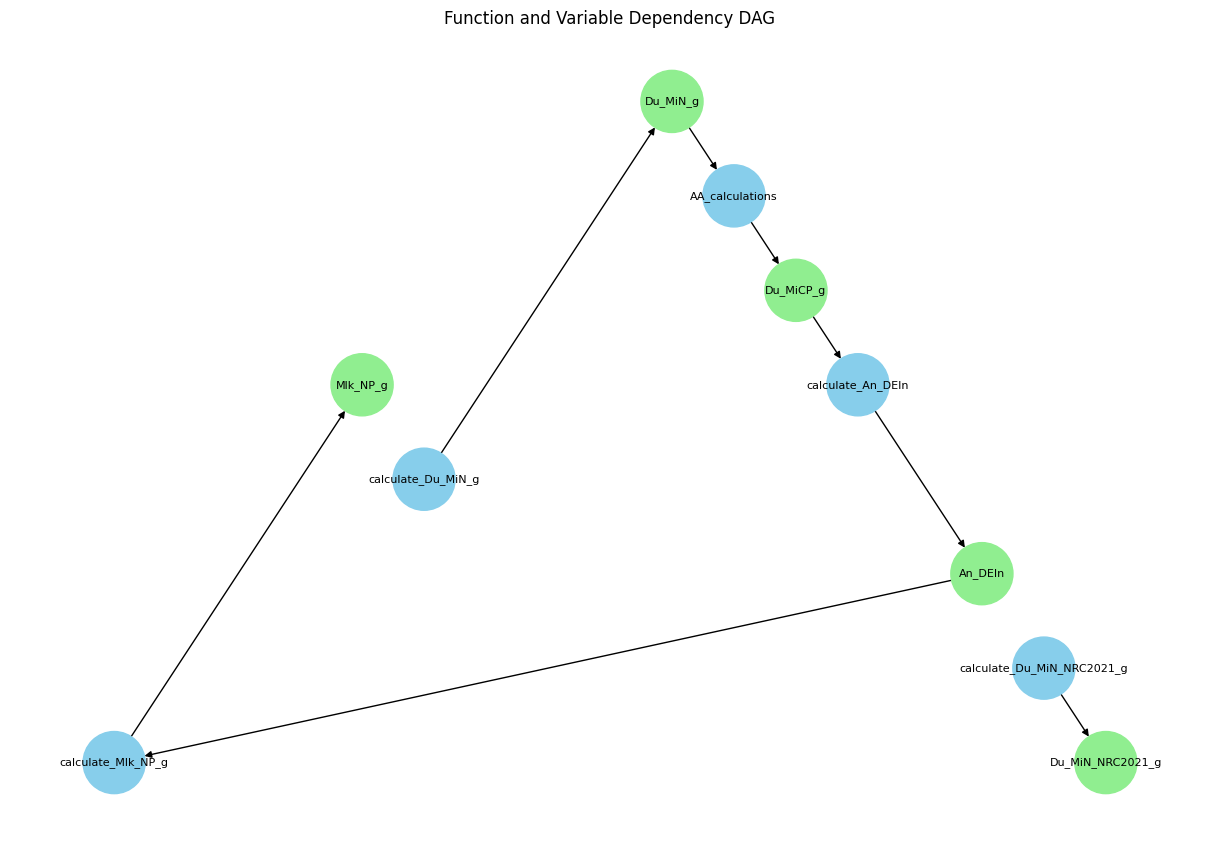

               function_names  \
0          calculate_Mlk_NP_g   
1             AA_calculations   
2           calculate_An_DEIn   
3          calculate_Du_MiN_g   
4  calculate_Du_MiN_NRC2021_g   

                                  function_arguments  function_returns  \
0  [An_BW, An_StatePhys, Dt_DMIn, df, Dt_idRUPIn,...          Mlk_NP_g   
1  [Du_MiN_g, feed_data, diet_info, animal_input,...         Du_MiCP_g   
2  [Dt_DigNDFIn_Base, Dt_NDFIn, Dt_DigStIn_Base, ...           An_DEIn   
3  [Dt_NDFIn, Dt_DMIn, Dt_StIn, Dt_CPIn, Dt_ADFIn...          Du_MiN_g   
4  [An_RDP, An_RDPIn, Dt_DMIn, Rum_DigNDFIn, Rum_...  Du_MiN_NRC2021_g   

  required_inputs  
0       [An_DEIn]  
1      [Du_MiN_g]  
2     [Du_MiCP_g]  
3            <NA>  
4            <NA>  


In [78]:
# Rewrite DAG_parse_file to be better documented
import pandas as pd
import ast
import os
import networkx as nx
import matplotlib.pyplot as plt

def DAG_parse_file(file_path):
    # Create lists to store results
    function_name_list = []
    function_arguments_list = []
    function_returns_list = []

    ### Read .py file ###
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")

    with open(file_path, 'r') as file:
        tree = ast.parse(file.read())

    ### Collect data from .py file ###
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
        ### Create list of funtion names ###
            function_name = node.name
            function_name_list.append(function_name)

        ### Create list of function arguments ###
            function_arguments = [arg.arg for arg in node.args.args]
            function_arguments_list.append(function_arguments)

        ### Create list of function returns ###
            for stmt in node.body:
                if isinstance(stmt, ast.Return):
                    # Get the returned variable names
                    function_returns_list.extend([var.id for var in ast.walk(stmt) if isinstance(var, ast.Name)])

    ### Create Dataframe with function info ###
    dev_DAG_data = pd.DataFrame()
    dev_DAG_data['function_names'] = function_name_list
    dev_DAG_data['function_arguments'] = function_arguments_list
    dev_DAG_data['function_returns'] = function_returns_list

    ### Create column with all required_inputs ###
    # Get all unique function returns
    unique_returns = dev_DAG_data['function_returns'].unique()
    # Keep only arguments that are returned by another function
    dev_DAG_data['required_inputs'] = dev_DAG_data['function_arguments'].apply(lambda arguments: [arg for arg in arguments if arg in unique_returns])
    dev_DAG_data['required_inputs'] = dev_DAG_data['required_inputs'].apply(lambda x: x if x else pd.NA)

    return dev_DAG_data       


def create_DAG(data):
    # Define function nodes
    functions = [value for value in data['function_names'].explode().unique() if value is not pd.NA]
    
    # Define variable nodes
    variables = [value for value in data['required_inputs'].explode().unique() if value is not pd.NA]
    
    # Define function edges
    function_edges = [(row['function_names'], row['function_returns']) for index, row in data.iterrows()]

    # Define variable edge
    variable_edges = [(value, row['function_names']) for index, row in data.iterrows() if isinstance(row['required_inputs'], list) for value in row['required_inputs'] if value is not pd.NA]

    # Create a new graph
    G = nx.DiGraph()
    # Add nodes
    G.add_nodes_from(functions)
    G.add_nodes_from(variables)
    # Add edges to represent dependencies
    G.add_edges_from(function_edges)     
    G.add_edges_from(variable_edges)

    # Assign colour to nodes
    groups = {node: 0 if node in functions else 1 for node in G.nodes()}
    color_map = ['skyblue' if groups[node] == 0 else 'lightgreen' for node in G.nodes()]

    # Plot and display the DAG
    plt.figure(figsize=(12, 8))
    # For positioning use one of the following equations: planar_layout, spring_layout
    pos = nx.planar_layout(G, scale=1.5)
    labels = {node: node for node in G.nodes()}
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=2000, font_size=8, font_color='black', node_color=color_map, arrows=True)
    plt.title("Function and Variable Dependency DAG")
    plt.show()


DAG_data = DAG_parse_file('./test_Mlk_NP_g_model.py')
create_DAG(DAG_data)
# print(DAG_data)

